<a href="https://colab.research.google.com/github/Chri1629/dsim_project/blob/main/audio/audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav
import librosa
import re
import seaborn as sns

import matplotlib.pyplot as plt


# Classification tools
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# Advanced audio features
import librosa.display
from sklearn.preprocessing import scale

import cv2


# Dati

Importiamo per prima cosa i dati da google drive. La strada deve essere quella prima di importare tutti i dati e poi di trasformarli in immagini. Una volta fatto questo le si salvano nuovamente dove sono già e poi le si importano con un image generator in modo che siano compatibili con la rete che vogliamo usare

In [29]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

base_dir = "gdrive/MyDrive/DigitalSignal/corretti/"

Mounted at /content/gdrive


## FUNZIONI

In [ ]:
def combo(input):
    return np.concatenate((aavg(input), duration(input), zcr(input), sdev(input)))

In [ ]:
def zcr(input, n_shift = 1):    
    # Remove all 0's as said before
    input = [x for x in input if x != 0]
    # It adds a number of 0 to the end equal to the n_shifts and deletes the first n_shift elements
    shifted = np.concatenate((input, np.zeros(n_shift)))[n_shift:]
    # If the signs agree and at least one of the two is 0, the value 0 is inserted, if the signs are discordant, the value 1 is inserted
    r = np.where((np.sign(shifted) * np.sign(input) >= 0),
                       0, 1)
    # Counts the number of 1's
    return np.sum(r[:-1], keepdims = True)

In [ ]:
def duration(input):
    return input.shape

In [ ]:
def aavg(input):
    return np.mean(np.abs(input), keepdims=True)

In [ ]:
def sdev(input):
    return np.std(input, keepdims = True)

In [ ]:
def crop(input, size =100):
    output = input[0:min(size, input.shape[0])]        
    # Aggiungo tanti zeri quanti ne passano tra la differenza tra la dimensione voluta e quella effettiva del file
    output = np.concatenate((output, np.zeros(size - output.shape[0])))        
    return output

In [ ]:
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []
    

    for f in sorted(os.listdir(base_dir)):
        if f.endswith('.mp3'):
            # Load file and compute the requested features cambiare la duration
            signal, sr = librosa.load(base_dir + f, duration= 7.0, sr=None)
            cur_features = feature_extractor(signal)
            features.append(cur_features)
            print(f)
            # Classes
            label = re.search(r'^(\d+)_([01])\.mp3$', f).group(2)
            labels.append(label)
            #print(labels)


    # X: features, y: labels
    X_train, X_validation, y_train, y_validation = train_test_split(features, labels, test_size=0.3, random_state=1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_validation = [row for row in (np.array(X_validation) - X_train_mean + eps)/(X_train_std + eps)]

    return X_train, X_validation, y_train, y_validation

## MODELLO 1

Se importiamo solo il dataloader senza aggiungere feature riusciamo a disegnare i diagrammi di MEL però perdiamo performance.

In [ ]:
X_train, X_validation, y_train, y_validation = load_data(feature_extractor=combo, normalize = True)

001_1.mp3
002_1.mp3
003_1.mp3
004_1.mp3
005_1.mp3
006_1.mp3
007_1.mp3
008_1.mp3
009_1.mp3
010_1.mp3
011_1.mp3
012_1.mp3
013_1.mp3
014_1.mp3
015_1.mp3
016_1.mp3
017_1.mp3
018_1.mp3
019_1.mp3
020_1.mp3
021_1.mp3
022_1.mp3
023_1.mp3
024_1.mp3
025_1.mp3
555_0.mp3
556_0.mp3
557_0.mp3
558_0.mp3
559_0.mp3
560_0.mp3
561_0.mp3
562_0.mp3
563_0.mp3
564_0.mp3
565_0.mp3
566_0.mp3
567_0.mp3
568_0.mp3
569_0.mp3
570_0.mp3
571_0.mp3
572_0.mp3
573_0.mp3
574_0.mp3
575_0.mp3
576_0.mp3
577_0.mp3
578_0.mp3
579_0.mp3


In [ ]:
print("La frequenza di campionamento è: {}".format(len(X_train[30])))

La frequenza di campionamento è: 4


In [ ]:
param_grid = {'C': [1e2, 5e2, 1e3],
            'gamma':[0.005, 0.01, 0.1, 0.5,1]}

clf = SVC(kernel ='rbf', class_weight='balanced')
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_validation)

In [ ]:
print(classification_report(y_validation, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.80      1.00      0.89         4

    accuracy                           0.93        15
   macro avg       0.90      0.95      0.92        15
weighted avg       0.95      0.93      0.94        15



Ora vanno aggiunte più feature durante il data loader

In [ ]:
cm = confusion_matrix(y_validation, y_pred)

fig = plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, annot_kws={"size": 16},
           linewidths=.1, cmap="YlGnBu")
plt.xlabel("True Class", size = 15)
plt.ylabel("Predicted Class", size = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
ax.yaxis.set_ticklabels(['Letto', 'Improvvisato']) 
ax.xaxis.set_ticklabels(['Letto', 'Improvvisato']) 
#ax.set_yticklabels(['Letto', 'Improvvisato'], rotation=90, ha='right', minor=False)

plt.title("Confusion matrix", size = 20)

NameError: ignored

Sarebbe interessante tenere una feature che senta il numero di silenzi

## Spectrogram

Proviamo a fare degli spettrogrammi. Per farlo dobbiamo reimportare nuovamente i dati ma senza aggiungere feature

In [ ]:
#X_train, X_validation, y_train, y_validation = load_data()

001_1.mp3
002_1.mp3
003_1.mp3
004_1.mp3
005_1.mp3
006_1.mp3
007_1.mp3
008_1.mp3
009_1.mp3
010_1.mp3
011_1.mp3
012_1.mp3
013_1.mp3
014_1.mp3
015_1.mp3
016_1.mp3
017_1.mp3
018_1.mp3
019_1.mp3
020_1.mp3
021_1.mp3
022_1.mp3
023_1.mp3
024_1.mp3
025_1.mp3
555_0.mp3
556_0.mp3
557_0.mp3
558_0.mp3
559_0.mp3
560_0.mp3
561_0.mp3
562_0.mp3
563_0.mp3
564_0.mp3
565_0.mp3
566_0.mp3
567_0.mp3
568_0.mp3
569_0.mp3
570_0.mp3
571_0.mp3
572_0.mp3
573_0.mp3
574_0.mp3
575_0.mp3
576_0.mp3
577_0.mp3
578_0.mp3
579_0.mp3


In [ ]:
#spect = librosa.feature.melspectrogram(y=X_train[2], n_mels=128)

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

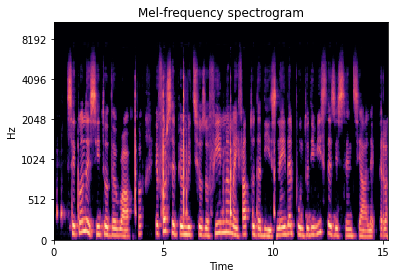

In [ ]:
#fig, ax = plt.subplots()
#S_dB = librosa.power_to_db(spect, ref=np.max)
#img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', ax=ax)
#plt.colorbar(img, ax=ax, format='%+2.0f dB')
#ax.set(title='Mel-frequency spectrogram')

In [ ]:
def create_spect():
  for f in sorted(os.listdir(base_dir)):
    if f.endswith('.mp3'):
            signal, sr = librosa.load(base_dir + f, duration= 7.0, sr=None) 
            print(f)
            name = re.search(r'^(\d+)_([01])\.mp3$', f).group(1)
            label = re.search(r'^(\d+)_([01])\.mp3$', f).group(2)
            spect = librosa.feature.melspectrogram(y=signal, n_mels=128)
            fig = plt.figure(figsize=(4,4))
            ax = fig.add_subplot(111)
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
            ax.set_frame_on(False)
            S_dB = librosa.power_to_db(spect, ref=np.max)
            img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', ax=ax)
            if int(label) == 0:
              fig.savefig("gdrive/MyDrive/spectrograms/letto/{}_{}.png".format(name, label), dpi = 100)
            else:
              fig.savefig("gdrive/MyDrive/spectrograms/improvvisato/{}_{}.png".format(name, label), dpi = 100)
            plt.close("all")

In [ ]:
create_spect()

001_1.mp3
002_1.mp3
003_1.mp3
004_1.mp3
005_1.mp3
006_1.mp3
007_1.mp3
008_1.mp3
009_1.mp3
010_1.mp3
011_1.mp3
012_1.mp3
013_1.mp3
014_1.mp3
015_1.mp3
016_1.mp3
017_1.mp3
018_1.mp3
019_1.mp3
020_1.mp3
021_1.mp3
022_1.mp3
023_1.mp3
024_1.mp3
025_1.mp3
026_1.mp3
027_1.mp3
028_1.mp3
029_1.mp3
030_1.mp3
031_1.mp3
032_1.mp3
033_1.mp3
034_1.mp3
035_1.mp3
036_1.mp3
037_1.mp3
038_1.mp3
039_1.mp3
040_1.mp3
041_1.mp3
042_1.mp3
043_1.mp3
044_1.mp3
045_1.mp3
046_1.mp3
047_1.mp3
048_1.mp3
049_1.mp3
050_1.mp3
051_1.mp3
052_1.mp3
053_1.mp3
054_1.mp3
055_1.mp3
056_1.mp3
057_1.mp3
058_1.mp3
059_1.mp3
060_1.mp3
061_1.mp3
062_1.mp3
063_1.mp3
064_1.mp3
065_1.mp3
066_1.mp3
067_1.mp3
068_1.mp3
069_1.mp3
070_1.mp3
071_1.mp3
072_1.mp3
073_1.mp3
074_1.mp3
075_1.mp3
076_1.mp3
077_1.mp3
078_1.mp3
079_1.mp3
080_1.mp3
081_1.mp3
082_1.mp3
083_1.mp3
084_1.mp3
085_1.mp3
086_1.mp3
087_1.mp3
088_1.mp3
089_1.mp3
090_1.mp3
091_1.mp3
092_1.mp3
093_1.mp3
094_1.mp3
095_1.mp3
096_1.mp3
097_1.mp3
098_1.mp3
099_1.mp3
100_0.mp3


## Split

Splittiamo ora la cartella spectrograms

In [ ]:
!pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio("gdrive/MyDrive/spectrograms", output="gdrive/MyDrive/spectrograms_model", ratio=(0.6, 0.3, 0.1))

Copying files: 800 files [00:10, 73.44 files/s]


# KERAS

importiamo ora i file con il generator di keras. Bisogna metterli nel formato corretto.

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import xception

Nel train generator si può introdurre anche un po' di rumore

In [7]:
train_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function = xception.preprocess_input)

train_generator = train_processing.flow_from_directory("gdrive/MyDrive/DigitalSignal/spectrograms_model/train",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 32,
                                    class_mode = "categorical",
                                    shuffle = True,
                                    seed = 1 )

Found 640 images belonging to 2 classes.


In [8]:
validation_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= xception.preprocess_input)

validation_generator = validation_processing.flow_from_directory("gdrive/MyDrive/DigitalSignal/spectrograms_model/val",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 32,
                                    class_mode = "categorical",
                                    shuffle = True,
                                    seed = 1)

Found 240 images belonging to 2 classes.


In [9]:
test_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= xception.preprocess_input)

test_generator = test_processing.flow_from_directory("gdrive/MyDrive/DigitalSignal/spectrograms_model/test",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 32,
                                    class_mode = "categorical",
                                    shuffle = True,
                                    seed = 1)

Found 80 images belonging to 2 classes.


In [11]:
from tensorflow.keras.applications import xception
base_net = xception.Xception(input_shape = (224,224,3),
                        weights = 'imagenet',
                        include_top = True,
                        pooling = 'avg')

ValueError: ignored

In [ ]:
for layer in base_net.layers:
    layer.trainable = False

In [ ]:
x = base_net.output

x = keras.layers.Dense(64, activation = "relu") (x)
pred = keras.layers.Dense(2, activation = 'sigmoid') (x)

In [ ]:
net1 = keras.Model(inputs = base_net.input, outputs = pred)

In [ ]:
net1.compile(loss = keras.losses.categorical_crossentropy,
           optimizer = keras.optimizers.RMSprop(),
           metrics = ['accuracy'])

In [ ]:
hist1 = net1.fit(train_generator,
       epochs = 10,
       validation_data = validation_generator)

Epoch 1/10
20/20 [==============================] - 8s 313ms/step - loss: 0.6396 - accuracy: 0.6985 - val_loss: 0.3855 - val_accuracy: 0.8708
Epoch 2/10
20/20 [==============================] - 6s 284ms/step - loss: 0.3846 - accuracy: 0.8312 - val_loss: 0.3518 - val_accuracy: 0.8250
Epoch 3/10
20/20 [==============================] - 5s 270ms/step - loss: 0.3127 - accuracy: 0.8595 - val_loss: 0.2642 - val_accuracy: 0.9125
Epoch 4/10
20/20 [==============================] - 5s 267ms/step - loss: 0.3247 - accuracy: 0.8555 - val_loss: 0.2540 - val_accuracy: 0.8750
Epoch 5/10
20/20 [==============================] - 5s 272ms/step - loss: 0.3040 - accuracy: 0.8701 - val_loss: 0.2172 - val_accuracy: 0.9375
Epoch 6/10
20/20 [==============================] - 5s 269ms/step - loss: 0.2786 - accuracy: 0.8979 - val_loss: 0.3551 - val_accuracy: 0.8208
Epoch 7/10
20/20 [==============================] - 5s 267ms/step - loss: 0.3255 - accuracy: 0.8378 - val_loss: 0.3555 - val_accuracy: 0.8417
Epoch 

In [16]:
def acc_loss(history):
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['loss'], label = "Train loss", color = "red")
    plt.plot(history.history['val_loss'], label="Validation loss", color = "skyblue")
    plt.legend(loc='upper right', fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel('Epochs', size = 15)
    plt.ylabel('Loss', size = 15) 
    
    plt.subplot(1,2,2)
    plt.plot(history.history['accuracy'], label = "Train accuracy", color = "red")
    plt.plot(history.history['val_accuracy'], label="Validation accuracy", color = "skyblue")
    plt.legend(loc='upper right', fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.xlabel('Epochs', size = 15)
    plt.ylabel('Accuracy', size = 15) 

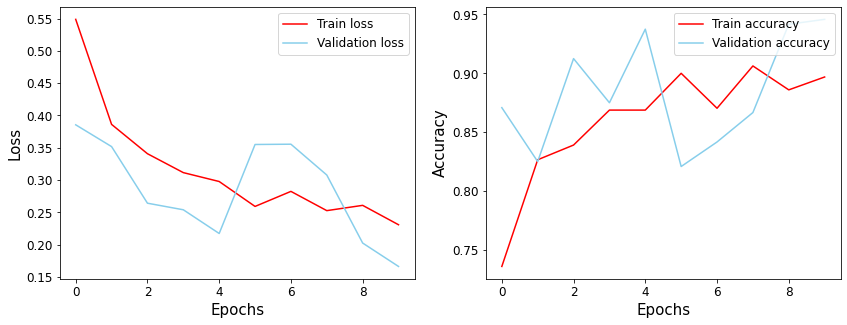

In [ ]:
acc_loss(hist1)

In [ ]:
acc1 = net1.evaluate(test_generator)

3/3 [==============================] - 1s 108ms/step - loss: 0.2799 - accuracy: 0.8125


In [ ]:
pred_1 = net1.predict(test_generator)

In [ ]:
pred_1 = np.argmax(pred_1, axis = 1)

In [ ]:
pred_1

array([0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1])

In [ ]:
print(classification_report(test_generator.classes, pred_1))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80        40
           1       0.78      0.88      0.82        40

    accuracy                           0.81        80
   macro avg       0.82      0.81      0.81        80
weighted avg       0.82      0.81      0.81        80



Text(0.5, 1.0, 'Confusion matrix')

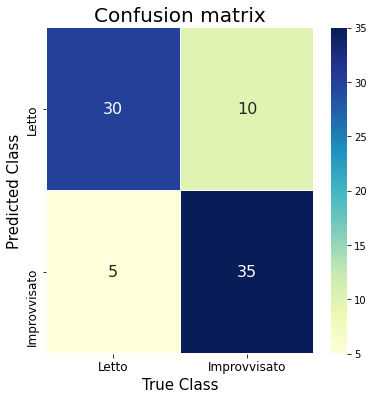

In [ ]:
cm = confusion_matrix(test_generator.classes, pred_1)

fig = plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, annot_kws={"size": 16},
           linewidths=.1, cmap="YlGnBu")
plt.xlabel("True Class", size = 15)
plt.ylabel("Predicted Class", size = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
ax.yaxis.set_ticklabels(['Letto', 'Improvvisato']) 
ax.xaxis.set_ticklabels(['Letto', 'Improvvisato']) 
#ax.set_yticklabels(['Letto', 'Improvvisato'], rotation=90, ha='right', minor=False)

plt.title("Confusion matrix", size = 20)

## Modello 2

In [ ]:
x = base_net.output

x = keras.layers.Dense(1024, activation = "relu") (x)
x = keras.layers.Dense(512, activation = "relu") (x)
pred = keras.layers.Dense(2, activation = 'sigmoid') (x)

In [ ]:
net2 = keras.Model(inputs = base_net.input, outputs = pred)

In [ ]:
net2.compile(loss = keras.losses.categorical_crossentropy,
           optimizer = keras.optimizers.RMSprop(),
           metrics = ['accuracy'])

In [ ]:
hist2 = net2.fit(train_generator,
       epochs = 10,
       validation_data = validation_generator)

Epoch 1/10
20/20 [==============================] - 8s 308ms/step - loss: 1.4528 - accuracy: 0.6582 - val_loss: 0.4841 - val_accuracy: 0.7292
Epoch 2/10
20/20 [==============================] - 5s 267ms/step - loss: 0.4992 - accuracy: 0.7724 - val_loss: 0.3114 - val_accuracy: 0.9125
Epoch 3/10
20/20 [==============================] - 5s 269ms/step - loss: 0.3402 - accuracy: 0.8594 - val_loss: 0.2419 - val_accuracy: 0.9167
Epoch 4/10
20/20 [==============================] - 5s 268ms/step - loss: 0.3492 - accuracy: 0.8399 - val_loss: 0.4490 - val_accuracy: 0.7792
Epoch 5/10
20/20 [==============================] - 5s 269ms/step - loss: 0.3665 - accuracy: 0.8507 - val_loss: 0.2289 - val_accuracy: 0.9375
Epoch 6/10
20/20 [==============================] - 5s 269ms/step - loss: 0.3194 - accuracy: 0.8749 - val_loss: 0.2374 - val_accuracy: 0.9292
Epoch 7/10
20/20 [==============================] - 5s 267ms/step - loss: 0.3198 - accuracy: 0.8574 - val_loss: 0.2061 - val_accuracy: 0.9125
Epoch 

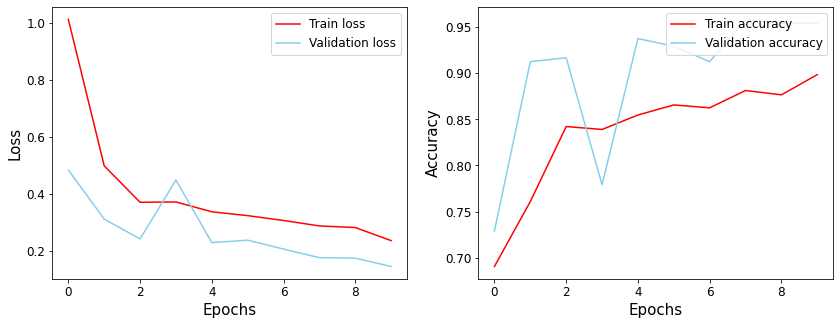

In [ ]:
acc_loss(hist2)

In [ ]:
acc2 = net2.evaluate(test_generator)

3/3 [==============================] - 1s 129ms/step - loss: 0.2715 - accuracy: 0.8375


In [ ]:
pred_2 = net2.predict(test_generator)

In [ ]:
pred_2 = np.argmax(pred_2, axis = 1)

In [ ]:
print(classification_report(test_generator.classes, pred_2))

              precision    recall  f1-score   support

           0       0.89      0.78      0.83        40
           1       0.80      0.90      0.85        40

    accuracy                           0.84        80
   macro avg       0.84      0.84      0.84        80
weighted avg       0.84      0.84      0.84        80



Text(0.5, 1.0, 'Confusion matrix')

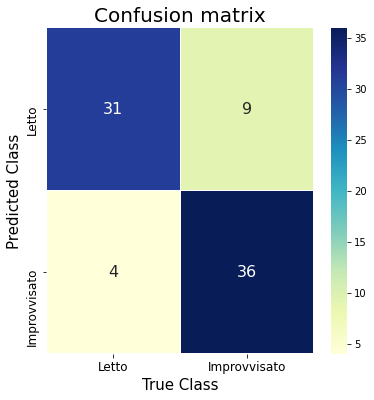

In [ ]:
cm = confusion_matrix(test_generator.classes, pred_2)

fig = plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, annot_kws={"size": 16},
           linewidths=.1, cmap="YlGnBu")
plt.xlabel("True Class", size = 15)
plt.ylabel("Predicted Class", size = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
ax.yaxis.set_ticklabels(['Letto', 'Improvvisato']) 
ax.xaxis.set_ticklabels(['Letto', 'Improvvisato']) 
#ax.set_yticklabels(['Letto', 'Improvvisato'], rotation=90, ha='right', minor=False)

plt.title("Confusion matrix", size = 20)

# CNN

Proviamo una rete non pre addestrata perché probabilmente hanno bisogno di più dati per funzionare meglio

In [12]:
from keras import layers

In [13]:
model = keras.Sequential(
    [
     keras.Input(shape = (224,224,3)),
     layers.Conv2D(16, kernel_size = (3,3), activation = 'relu'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Conv2D(16, kernel_size = (3,3), activation = 'relu'),
     layers.MaxPooling2D(pool_size = (2,2)),
     layers.Flatten(),
     layers.Dense(124, activation = "relu"),
     layers.Dropout(0.5),
     layers.Dense(2, activation = 'softmax')
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 46656)             0         
_________________________________________________________________
dense (Dense)                (None, 124)               5785468   
_________________________________________________________________
dropout (Dropout)            (None, 124)               0

In [14]:
model.compile(loss = "categorical_crossentropy",
              optimizer = keras.optimizers.Adam(),
              metrics = ["accuracy"])

histo_best = model.fit(train_generator, 
                       epochs = 30, 
                       batch_size = 128, 
                       validation_data = validation_generator)

Epoch 1/30
20/20 [==============================] - 328s 16s/step - loss: 2.5747 - accuracy: 0.5056 - val_loss: 0.6075 - val_accuracy: 0.7208
Epoch 2/30
20/20 [==============================] - 4s 225ms/step - loss: 0.5779 - accuracy: 0.6907 - val_loss: 0.4555 - val_accuracy: 0.8333
Epoch 3/30
20/20 [==============================] - 4s 225ms/step - loss: 0.4410 - accuracy: 0.8159 - val_loss: 0.3375 - val_accuracy: 0.8750
Epoch 4/30
20/20 [==============================] - 4s 226ms/step - loss: 0.3248 - accuracy: 0.8652 - val_loss: 0.2459 - val_accuracy: 0.9167
Epoch 5/30
20/20 [==============================] - 4s 226ms/step - loss: 0.2557 - accuracy: 0.9026 - val_loss: 0.1763 - val_accuracy: 0.9500
Epoch 6/30
20/20 [==============================] - 4s 225ms/step - loss: 0.1658 - accuracy: 0.9530 - val_loss: 0.1711 - val_accuracy: 0.9292
Epoch 7/30
20/20 [==============================] - 4s 226ms/step - loss: 0.1374 - accuracy: 0.9565 - val_loss: 0.1048 - val_accuracy: 0.9625
Epoch 

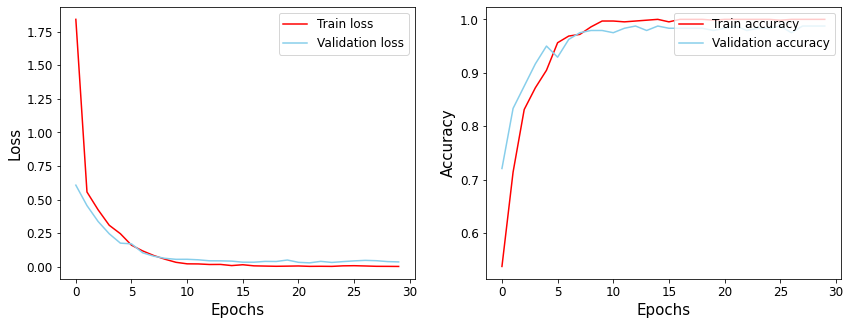

In [17]:
acc_loss(histo_best)

In [18]:
acc_best = model.evaluate(test_generator)

3/3 [==============================] - 18s 9s/step - loss: 0.1877 - accuracy: 0.9500


In [19]:
yc_pred = model.predict(test_generator)
y_pred_best = np.argmax(yc_pred, axis = 1)

In [20]:
print(classification_report(test_generator.classes, y_pred_best))

              precision    recall  f1-score   support

           0       0.61      0.57      0.59        40
           1       0.60      0.62      0.61        40

    accuracy                           0.60        80
   macro avg       0.60      0.60      0.60        80
weighted avg       0.60      0.60      0.60        80



Text(0.5, 1.0, 'Confusion matrix')

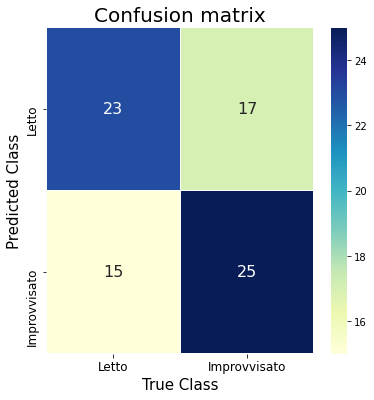

In [21]:
cm = confusion_matrix(test_generator.classes, y_pred_best)
fig = plt.figure(figsize = (6,6))
ax = plt.subplot()
sns.heatmap(cm, annot=True, annot_kws={"size": 16},
           linewidths=.1, cmap="YlGnBu")
plt.xlabel("True Class", size = 15)
plt.ylabel("Predicted Class", size = 15)
plt.xticks(size = 12)
plt.yticks(size = 12)
ax.yaxis.set_ticklabels(['Letto', 'Improvvisato']) 
ax.xaxis.set_ticklabels(['Letto', 'Improvvisato']) 
#ax.set_yticklabels(['Letto', 'Improvvisato'], rotation=90, ha='right', minor=False)

plt.title("Confusion matrix", size = 20)

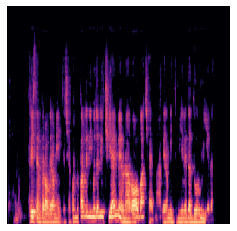

In [30]:
path = "gdrive/MyDrive/DigitalSignal/"
signal, sr = librosa.load(path + "prova4.mp3", duration= 7.0, sr=None) 
spect = librosa.feature.melspectrogram(y=signal, n_mels=128)
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_frame_on(False)
S_dB = librosa.power_to_db(spect, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', ax=ax)
fig.savefig(path + "single/test/"+"prova4.png", dpi = 100)

In [31]:
single_processing = keras.preprocessing.image.ImageDataGenerator(preprocessing_function= xception.preprocess_input)

single_generator = single_processing.flow_from_directory("gdrive/MyDrive/DigitalSignal/single",
                                    target_size = (224, 224),
                                    color_mode = "rgb",
                                    batch_size = 1,
                                    class_mode = "categorical",
                                    shuffle = False,
                                    seed = 1)

Found 4 images belonging to 1 classes.


In [32]:
prova_pred = model.predict(single_generator)
result = np.argmax(prova_pred, axis = 1)
result

array([1, 0, 0, 1])

In [33]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in result]

In [34]:
predictions

['letto', 'improvvisato', 'improvvisato', 'letto']

In [35]:
prova_pred

array([[7.8752168e-02, 9.2124778e-01],
       [9.9908340e-01, 9.1659132e-04],
       [9.9955910e-01, 4.4082550e-04],
       [3.8971175e-02, 9.6102881e-01]], dtype=float32)

In [36]:
train_generator.class_indices

{'improvvisato': 0, 'letto': 1}